<a href="https://colab.research.google.com/github/kadinsayani/MLModels/blob/main/Titanic_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Linear Regression ML model to predict passenger survival on the Titanic

## Import libraries and load dataset

In [ ]:
!pip install -q sklearn

In [ ]:
%tensorflow_version 2.x

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib 
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [ ]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # test data
print(dftrain.head())
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
print(dftrain.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
      sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]


## Exploratory data analysis

In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
dftrain.shape

(627, 9)

In [ ]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

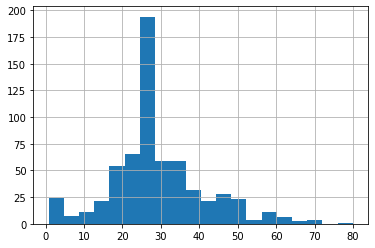

In [ ]:
dftrain.age.hist(bins=20)

In [ ]:
dftrain.sex.value_counts()

male      410
female    217
Name: sex, dtype: int64

In [ ]:
dftrain["class"].value_counts()

Third     341
First     159
Second    127
Name: class, dtype: int64

Text(0.5, 0, '% survive')

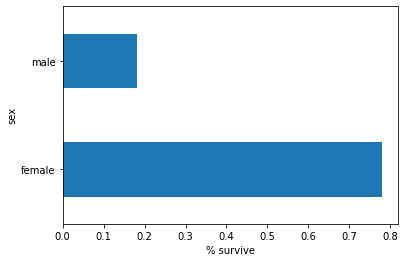

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

After initialy analyzing the dataset we can conclude that:


*   The majority of passengers are between the age of 20 and 30
*   There are more males than females
*   Majority of passengers are in 3rd class
*   Females are much more likely to survive than males



## Encoding and identifying feature columns

In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

## Input function

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function to be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create a tf.data.Dataset object
    if shuffle:
      ds = ds.shuffle(1000) # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repeat process for number of epochs
    return ds # return a batch of dataset
  return input_function # return a function objevt for use

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

## Creating the model

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprg3xgg_y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training the model

In [ ]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])

0.75757575


## Making predictions

In [ ]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[2])
print(y_eval.loc[2])
print(result[2]['probabilities'][1])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprg3xgg_y/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
emb